In [170]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tslearn.datasets import UCR_UEA_datasets
import sklearn
import pickle
import numpy as np 
import torch 
from TSInterpret_Artifacts.ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, fit
import warnings
warnings.filterwarnings("ignore") 

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tslearn.shapelets import LearningShapelets

In [205]:
# Plot single Time Series with Label
def plot_ts(ts_sample):
    ts= ts_sample
    plt.figure(figsize=(10, 4))
    plt.plot(ts, label="Time Series", color='blue')
    plt.title(f"Time Series")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()


def scale_dataset(data):
    minmaxscaler = MinMaxScaler()
    scaled_data = [minmaxscaler.fit_transform(ts) for ts in data]
    return scaled_data


def diff_dataset(data):
    return [ts[1:] - ts[:-1] for ts in data]


def time_series_to_zero(ts, start, end):
    out = ts.copy()
    out[start:end] = 0
    return out


def time_series_interpolate_linear(ts, start, end):
     out = ts.copy()
     out[start:end] = np.interp(list(range(start, end)), [start, end], [out[start][0], out[end][0]]).reshape(end - start,1)
     return out


def time_series_to_mean(ts, start, end, data):
    out = ts.copy()
    out[start:end] = np.array([np.mean([ts[i] for ts in data]) for i in range(start, end)]).reshape(end - start,1)
    return out

In [139]:
dataset='Coffee'
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)

In [ ]:
# Scale Datasets

train_x = scale_dataset(train_x)
test_x = scale_dataset(test_x)

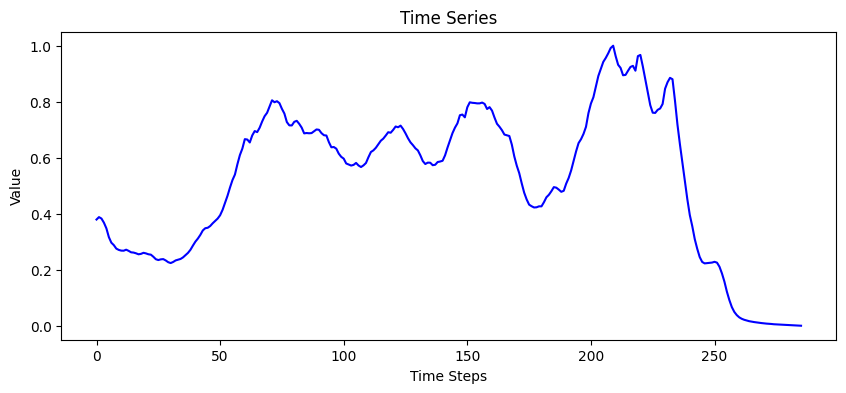

In [198]:
plot_ts(train_x[0])

In [199]:
train_x_diff = diff_dataset(train_x)
test_x_diff = diff_dataset(test_x)

In [200]:
# Shorten Time Series

train_x_diff = [ts[:250] for ts in train_x_diff]
test_x_diff = [ts[:250] for ts in test_x_diff]

train_x = [ts[:250] for ts in train_x]
test_x = [ts[:250] for ts in test_x]

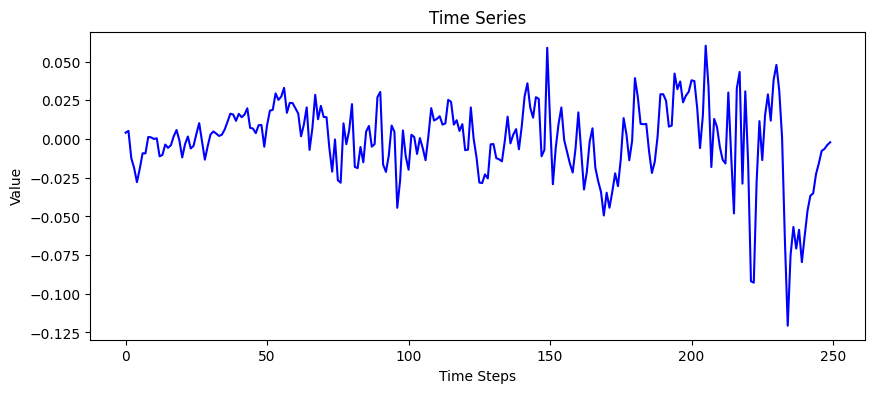

In [201]:
plot_ts(train_x_diff[1])

In [202]:
model = LearningShapelets(n_shapelets_per_size={30: 1})
model.fit(train_x_diff, train_y)
train_distances = model.transform(train_x_diff)
test_distances = model.transform(test_x_diff)
shapelets = model.shapelets_

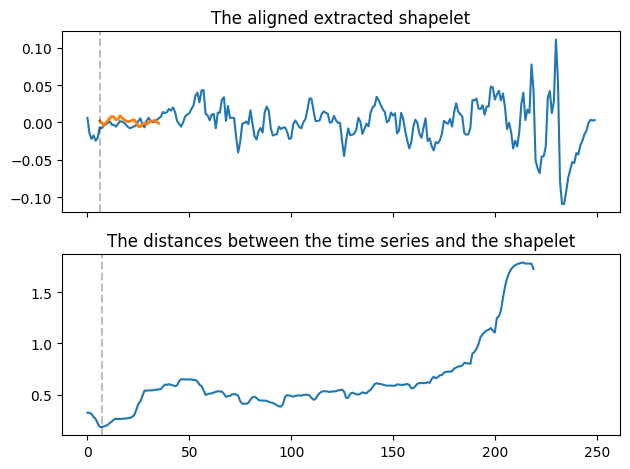

In [203]:
# 0 - 13 Label 0; 14 - 27 Label 1

distances = model.transform(train_x_diff) # blackbox model and manually calculated distances are not the same!
predicted_locations = model.locate(train_x_diff)

f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = 15 #np.argmin(np.sum(distances, axis=1))
shap = model.shapelets_[0]
#shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]

ax[0].plot(train_x_diff[test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances_man = []
time_series = train_x_diff[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances_man.append(np.linalg.norm(time_series[i:i+len(shap)] - shap)) # Dynamic Time Warping als Distanzmetrik
ax[1].plot(distances_man)
ax[1].axvline(np.argmin(distances_man), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()

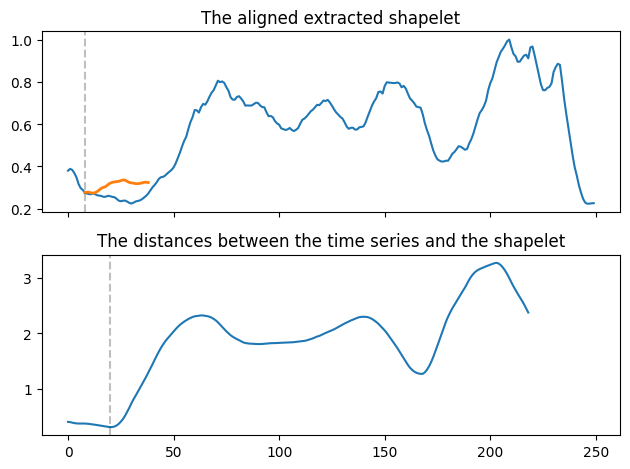

In [204]:
f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = 0 #np.argmin(np.sum(distances, axis=1))
shap = model.shapelets_[0]
#shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]
shap_undiff = np.cumsum(np.concatenate([train_x[test_ts_id][pos].reshape(1,-1), shap]))

ax[0].plot(train_x[test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap_undiff)), shap_undiff, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances_man = []
time_series = train_x[test_ts_id].ravel()
for i in range(len(time_series) - len(shap_undiff)):
    distances_man.append(np.linalg.norm(time_series[i:i+len(shap_undiff)] - shap_undiff)) # Dynamic Time Warping als Distanzmetrik
ax[1].plot(distances_man)
ax[1].axvline(np.argmin(distances_man), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()

In [97]:
train_x[test_ts_id][pos]

array([-0.90632072])

In [98]:
shap_undiff = np.cumsum(np.concatenate([train_x[test_ts_id][pos].reshape(1,-1), shap]))

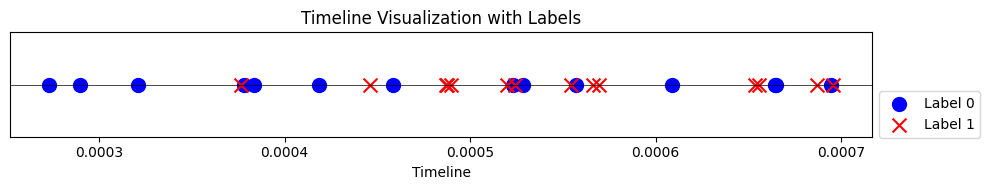

In [93]:
data = train_distances.flatten()
labels = train_y

# Marker styles for labels
marker_styles = {0: 'o', 1: 'x'}
colors = {0: 'blue', 1: 'red'}

# Create the figure and axis
plt.figure(figsize=(10, 2))
plt.axhline(0, color='black', linewidth=0.5)  # Timeline baseline

# Plot points on the timeline
for dist, label in zip(data, labels):
    plt.scatter(dist, 0, marker=marker_styles[label], color=colors[label], s=100, label=f'Label {label}')

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 0.5))

# Add annotations for each point
# for number in data:
#     plt.text(number, 0.1, str(number), ha='center', va='bottom', fontsize=9)

# Adjust timeline aesthetics
plt.yticks([])  # Remove y-axis ticks
plt.xlabel('Timeline')
plt.title('Timeline Visualization with Labels')
plt.tight_layout()
plt.show()

In [62]:
test_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [31]:
test_back_transformed = np.cumsum(np.concatenate([train_x[0][0].reshape(1,-1), test_transformed]))

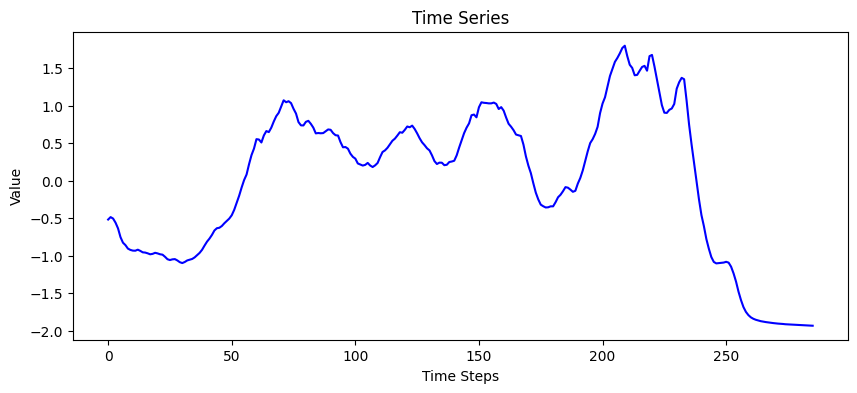

In [32]:
plot_ts(test_back_transformed)

In [142]:
test = train_x[0]

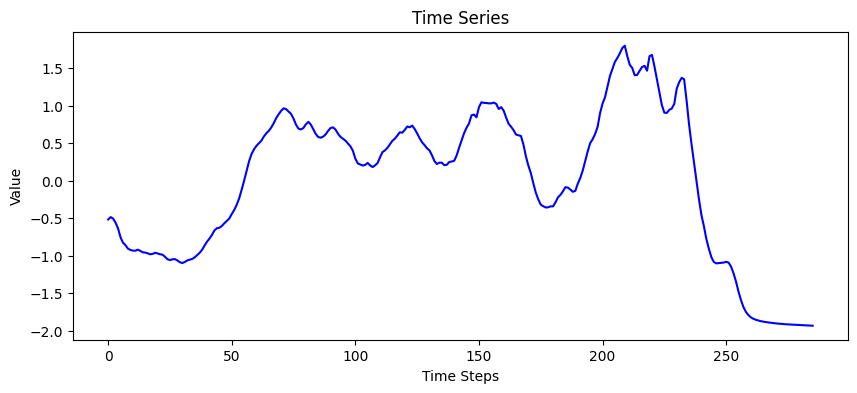

In [194]:
plot_ts(time_series_to_mean(test, 50, 100, train_x))

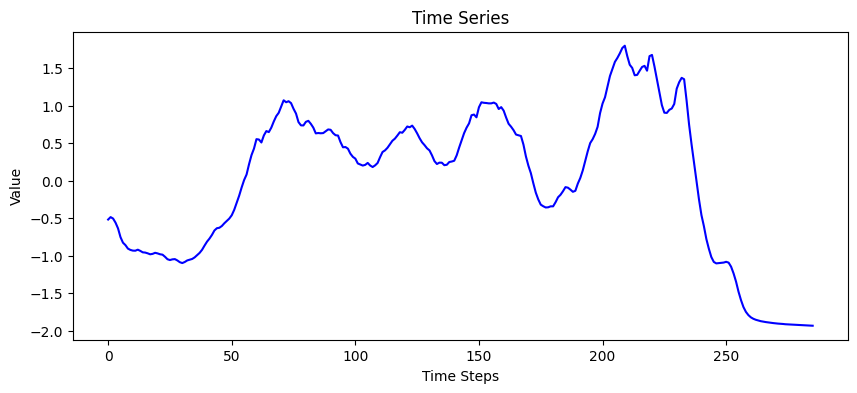

In [182]:
plot_ts(train_x[0])

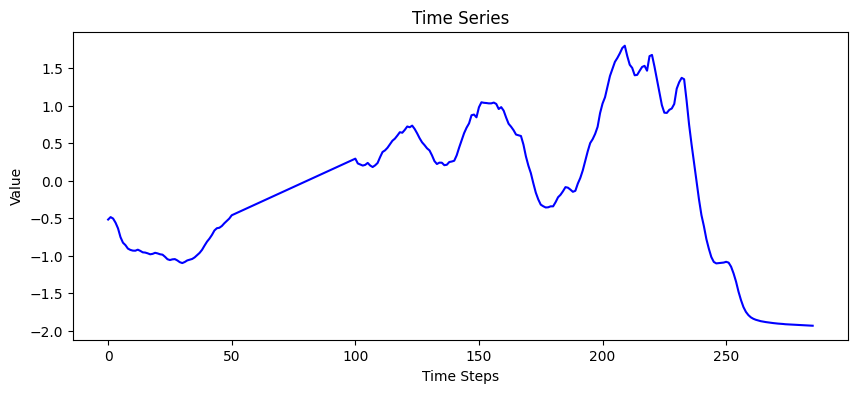

In [166]:
plot_ts(time_series_interpolate_linear(test, 50, 100))

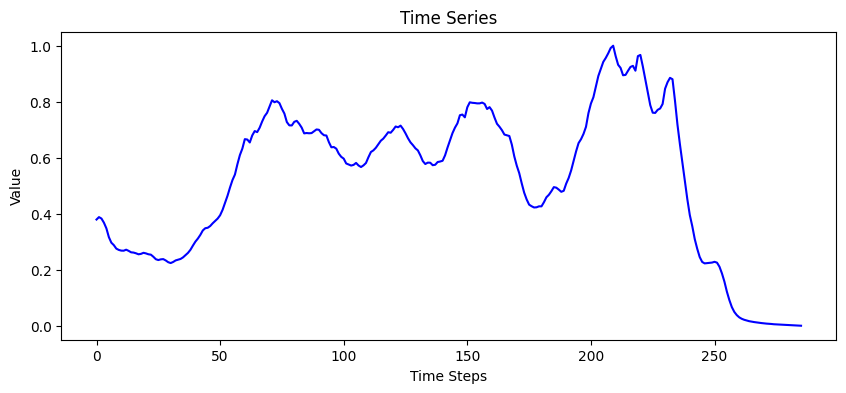

In [181]:
plot_ts(train_x_scaled[0])

In [171]:
minmaxscaler = MinMaxScaler()
sctest = minmaxscaler.fit_transform(test)

In [178]:
def scale_dataset(data):
    scaled_data = [minmaxscaler.fit_transform(ts) for ts in data]
    return scaled_data

In [179]:
train_x_scaled = scale_dataset(train_x)

In [180]:
train_x_scaled

[array([[3.79205925e-01],
        [3.87909162e-01],
        [3.82793518e-01],
        [3.68034033e-01],
        [3.47672812e-01],
        [3.16394041e-01],
        [2.96598943e-01],
        [2.87895664e-01],
        [2.75441881e-01],
        [2.70767100e-01],
        [2.68248381e-01],
        [2.67922822e-01],
        [2.71572096e-01],
        [2.67349661e-01],
        [2.62153473e-01],
        [2.61258908e-01],
        [2.58566517e-01],
        [2.55089137e-01],
        [2.56642242e-01],
        [2.60406984e-01],
        [2.58322305e-01],
        [2.55199650e-01],
        [2.53736626e-01],
        [2.46311177e-01],
        [2.37526208e-01],
        [2.34535281e-01],
        [2.37038206e-01],
        [2.37881716e-01],
        [2.33155912e-01],
        [2.26897757e-01],
        [2.23810369e-01],
        [2.27623273e-01],
        [2.33211392e-01],
        [2.35797671e-01],
        [2.38478003e-01],
        [2.44059756e-01],
        [2.51929518e-01],
        [2.60087572e-01],
        [2.7